In [1]:
import numpy as np 
import pandas as pd 
import scipy as sp 
from sklearn.linear_model import LinearRegression
import seaborn as sns 
import random

import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap

import sys 

print('python version:', sys.version) 
print('pandas version:', pd.__version__)

pd.set_option('display.max_columns', 50)
pd.set_option('precision', 12)

python version: 3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]
pandas version: 0.23.4


In [2]:
df = pd.read_csv('./chicago-food-inspections.csv')
print(df.shape)

(186354, 22)


In [3]:
df.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards
0,2288249,SPILT MILK,SPILT MILK,2663633.0,Bakery,Risk 2 (Medium),1844 S BLUE ISLAND AVE,CHICAGO,IL,60608.0,05/03/2019,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.856730538799,-87.662299836259,"(41.85673053879921, -87.66229983625918)",8.0,14920.0,33.0,365.0,26.0
1,2288219,"TEDDY BEAR NURSERY SCHOOL, INC","TEDDY BEAR NURSERY SCHOOL, INC",2215477.0,Daycare Above and Under 2 Years,Risk 1 (High),6401 S PULASKI RD,CHICAGO,IL,60629.0,05/03/2019,License,Pass,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICE...,41.776783362512,-87.722565512035,"(41.776783362511694, -87.72256551203533)",23.0,21867.0,63.0,238.0,15.0
2,2288221,PALETERIA AYUTLA,PALETERIA AYUTLA,2321232.0,Restaurant,Risk 2 (Medium),2404 W 46TH PL,CHICAGO,IL,60632.0,05/03/2019,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.809456917362,-87.684745989347,"(41.80945691736228, -87.68474598934672)",29.0,14924.0,55.0,687.0,3.0
3,2288215,PALATERIA AYUTLA,PALETERIA AYUTLA,2252810.0,Mobile Frozen Desserts Vendor,Risk 3 (Low),2404 W 46TH PL,CHICAGO,IL,60632.0,05/03/2019,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.809456917362,-87.684745989347,"(41.80945691736228, -87.68474598934672)",29.0,14924.0,55.0,687.0,3.0
4,2288224,"LA V BAKERY, INC","LA V BAKERY, INC",2550054.0,Bakery,Risk 2 (Medium),2338 S KEDZIE AVE,CHICAGO,IL,60623.0,05/03/2019,Canvass,Out of Business,NaN,41.848790495081,-87.705310981559,"(41.84879049508066, -87.70531098155864)",36.0,21569.0,32.0,291.0,1.0


In [4]:
df.isna().sum().sort_values(ascending=False)

Violations                    49607
Facility Type                  4751
Historical Wards 2003-2015     3300
Wards                          3300
Community Areas                3300
AKA Name                       2451
Census Tracts                   693
Zip Codes                       664
Location                        664
Longitude                       664
Latitude                        664
City                            161
Zip                              79
Risk                             75
State                            34
License #                        16
Inspection Type                   1
DBA Name                          0
Inspection Date                   0
Address                           0
Results                           0
Inspection ID                     0
dtype: int64

In [5]:
df.Results.value_counts()

Pass                    103503
Fail                     35942
Pass w/ Conditions       23220
Out of Business          16211
No Entry                  5782
Not Ready                 1630
Business Not Located        66
Name: Results, dtype: int64

In [44]:
(df.Results == 'Fail').sum() / df.Results.count()

0.19286948495873446

### Restaurants failed the food inspection

This plot is definitely misleading. Because there are more restaurants in Northern Chicago, there would also be higher number of failed resturants. 

We should compare the fail rate of restaurants.

In [89]:
failed_coord = df[df.Results == 'Fail'][['Latitude', 'Longitude']].values

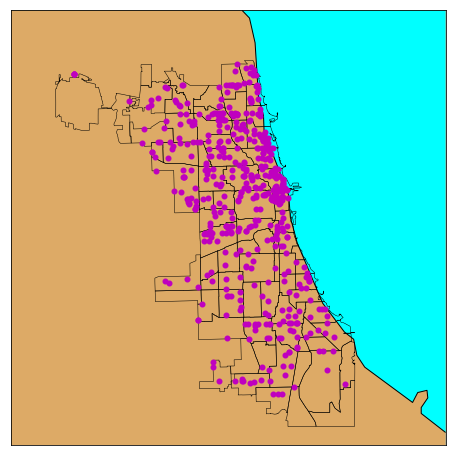

In [90]:
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=41.85, lon_0=-87.7,
            width=5E4, height=5E4)

m.fillcontinents(color='#ddaa66',lake_color='aqua')
m.readshapefile('geo_export_8f5b8083-f611-4548-bc8d-938143e844b2', name='chicago')
m.shadedrelief()
m.drawcoastlines()

for lat, lon in failed_coord[np.random.choice(len(failed_coord), 500, replace=False)]: 
    m.plot(lon, lat, marker='.', color='m', markersize=8, markeredgewidth=2, latlon=True)

### Zip code regions with highest & lowest Fail rate

In [85]:
zipmask = (df.groupby('Zip').Results.count() > 20)

In [86]:
zip_fail_rate = ((df[df.Results == 'Fail'].groupby('Zip').Results.count()) / \
    df.groupby('Zip').Results.count())[zipmask].sort_values(ascending=False)

In [87]:
zip_fail_rate.head(10)

Zip
60615.0    0.275534441805
60637.0    0.270561797753
60619.0    0.254027926960
60628.0    0.249264273102
60623.0    0.246260796292
60644.0    0.244151424926
60653.0    0.243478260870
60636.0    0.238864628821
60651.0    0.237923576063
60640.0    0.230722525804
Name: Results, dtype: float64

In [88]:
zip_fail_rate.tail(10)

Zip
60618.0    0.145848119233
60602.0    0.142962417097
60654.0    0.142678034102
60652.0    0.138954869359
60638.0    0.132433572332
60193.0    0.130434782609
60666.0    0.129774127310
60606.0    0.129148866250
60604.0    0.126482213439
60601.0    0.124803025528
Name: Results, dtype: float64

### Fail rate for different facility types

In [31]:
df['Facility Type'].value_counts().head(15)

Restaurant                         123783
Grocery Store                       23988
School                              11860
Children's Services Facility         2725
Bakery                               2707
Daycare (2 - 6 Years)                2637
Daycare Above and Under 2 Years      2176
Long Term Care                       1244
Catering                             1105
Mobile Food Dispenser                 843
Liquor                                830
Daycare Combo 1586                    780
Mobile Food Preparer                  551
Golden Diner                          538
Wholesale                             530
Name: Facility Type, dtype: int64

In [48]:
factype_mask = (df.groupby('Facility Type').Results.count() > 100)

In [49]:
factype_fail_rate = ((df[df.Results == 'Fail'].groupby('Facility Type').Results.count()) / \
    df.groupby('Facility Type').Results.count())[factype_mask].sort_values(ascending=False)

In [50]:
factype_fail_rate.head(10)

Facility Type
Liquor                   0.357831325301
TAVERN                   0.345238095238
Wholesale                0.341509433962
Mobile Food Dispenser    0.297746144721
Mobile Food Preparer     0.290381125227
GAS STATION              0.271929824561
Grocery Store            0.237326996832
Daycare Combo 1586       0.237179487179
BANQUET HALL             0.234042553191
Long Term Care           0.222668810289
Name: Results, dtype: float64

In [51]:
factype_fail_rate.tail(10)

Facility Type
Daycare (2 - 6 Years)              0.191505498673
Golden Diner                       0.191449814126
Shared Kitchen                     0.186274509804
Restaurant                         0.185510126593
Children's Services Facility       0.174678899083
Daycare Above and Under 2 Years    0.171875000000
Special Event                      0.160975609756
Catering                           0.159276018100
Hospital                           0.143712574850
Shared Kitchen User (Long Term)    0.026041666667
Name: Results, dtype: float64

In [93]:
factype_fail_rate.shape

(25,)

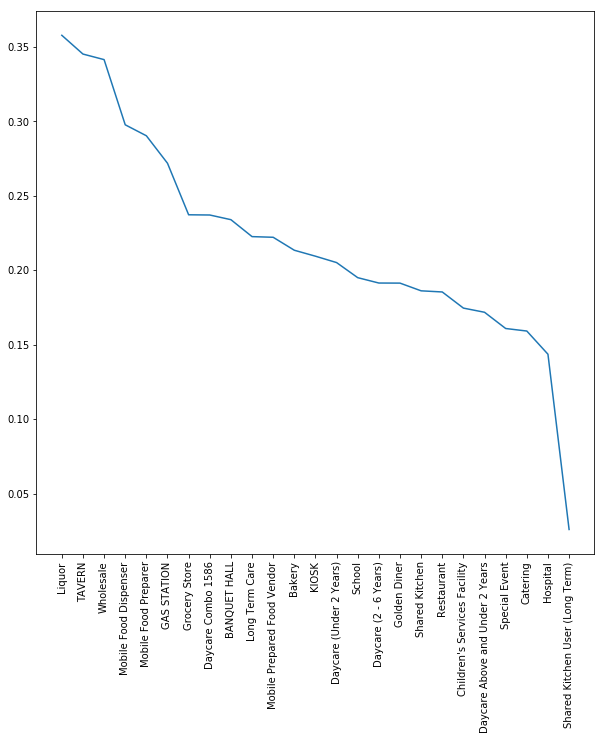

In [98]:
plt.figure(figsize=(10, 10))
plt.plot(factype_fail_rate)
plt.xticks(rotation=90)
plt.show()